# Setup

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import dill as pickle
import time

from deap import algorithms, base, creator, tools

from sympy import *

from scipy.stats import spearmanr

sys.path.append('../../promoter_solving/')
from promoter_solving_core import *

In [10]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [11]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [12]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [13]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

## Individual Grid

In [14]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor' # Solve for this by setting the other (e.g. solve = cInhibitor if cActivator is known)

input_range = {
    'cActivator': [0,100],
    #'cInhibitor': [0,50],
}

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 101, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values[list(input_range.keys())[0]] = pair[0] #NOTE: May break if we try to run both at same time
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Remove negative elements from working_grid
    working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

## Combined Grid

In [15]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

cAct_range = {'cActivator': [0,2]} # Use a log10 range
cInh_range = {'cInhibitor': [-1,4]} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = create_parameter_grid(num_steps = 101, **cAct_range)
    cAct_grid = [[10**x[0]] for x in cAct_grid]
    cInh_grid = create_parameter_grid(num_steps = 101, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function
        cAct_grid[ii] = (cAct_grid[ii][0], (lambda_df.loc['cInhibitor','lambda'](values_tuple))[0])

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0], cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids
    
    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Remove negative elements from working_grid
    working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]

    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [16]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.07390374033635091, 0.1), (0.07515356672096..."
control__wt_glc__2,2.369230,"[(0.0884301336265355, 0.1), (0.089846416823985..."
fur__wt_dpd__1,0.490542,"[(0.0011348626582396613, 1.2589254117941675), ..."
fur__wt_dpd__2,0.492320,"[(0.001277544681404343, 1.2589254117941675), (..."
fur__wt_fe__1,1.756930,"[(0.044264401834296155, 0.1), (0.0451745933403..."


# DEAP

In [17]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               shape = (274,), # Number of conditions
               dtype = np.dtype([('act', float), ('inh', float)]), # Custom dtype
               fitness = creator.fitness)

toolbox = base.Toolbox()

def generate_individual(individual_class: type, grid: pd.Series):
    '''
    Randomly pick tuples from each condition's grid to create an individual
    
    :param type individual_class: Class that the individual will inherit from
    :param pd.Series grid: Contains the parameter grids for each condition
    '''
    individual = np.empty(shape=individual_class.shape, dtype=individual_class.dtype)

    for i, condition in enumerate(grid):
        individual[i] = tuple(rng.choice(a=condition, size=1, replace=False)[0])
        
    return individual_class(individual)

toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 grid = grid.grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
# Evaluate
MA_df = data.iloc[:,0:2]

def spearman_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate spearman coefficient between cAct/cInh and MA_act/MA_inh
    
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """

    # Create arrays with the ordered condition parameters
    MA_activator = MA_df.loc[:,'MA_activator']
    MA_inhibitor = MA_df.loc[:,'MA_inhibitor']

    ind_activator = individual['act']
    ind_inhibitor = individual['inh']
    
    # Calculate the spearman rank coefficient
    activator_spearman = spearmanr(MA_activator, ind_activator)[0]
    inhibitor_spearman = spearmanr(MA_inhibitor, ind_inhibitor)[0]
    
    return activator_spearman, inhibitor_spearman,

toolbox.register(alias = 'evaluate',
                function = spearman_objective,
                MA_df = MA_df)

In [19]:
toolbox.register("select", tools.selNSGA2, nd='log') # I've been using selNSGA2 since it seems to run faster
#toolbox.register("select", tools.selSPEA2)

In [20]:
# Mutation
def mutate(individual: object, prob: float, grid: pd.Series):
    # Iterate over all conditions if an individual is selected to mutate
    for i, _ in enumerate(individual):
        if rng.random() < prob:
            # Select a new set of parameters for a condition from the grid
            # Requires the "grid" to be in a specific location of the dataframe
            individual[i] = tuple(rng.choice(a=grid.iloc[i], size=1, replace=False)[0])

    return individual

In [21]:
# Crossover
def crossover(ind_one: object, ind_two: object, prob: float):
    # Individuals are already deep-copied before going into this function
    for i, _ in enumerate(ind_one):
        if rng.random() < prob:
            # Use copies to avoid modifying the np.array in place
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

In [22]:
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],ind.fitness.values[1]))

In [23]:
def best_individual(population: list):
    """
    Returns a list containing the total scores for each individual and a list 
    containining the np.argsort indices for the ascending sorted scores

    :param list population: List of individuals with fitness scores
    """
    a, b = zip(*[population[i].fitness.values for i in range(len(population))])
    total_scores = np.subtract(a,b) # Since objective weights are (1.0, -1.0)
    sorted_index = np.argsort(total_scores)

    return total_scores, sorted_index

In [24]:
# Copied directly from DEAP, updated to use np.random
def var_or(population, toolbox, lambda_, cxpb, mutpb):
    r"""Part of an evolutionary algorithm applying only the variation part
    (crossover, mutation **or** reproduction). The modified individuals have
    their fitness invalidated. The individuals are cloned so returned
    population is independent of the input population.

    :param population: A list of individuals to vary.
    :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                    operators.
    :param lambda\_: The number of children to produce
    :param cxpb: The probability of mating two individuals.
    :param mutpb: The probability of mutating an individual.
    :returns: The final population.

    The variation goes as follow. On each of the *lambda_* iteration, it
    selects one of the three operations; crossover, mutation or reproduction.
    In the case of a crossover, two individuals are selected at random from
    the parental population :math:`P_\mathrm{p}`, those individuals are cloned
    using the :meth:`toolbox.clone` method and then mated using the
    :meth:`toolbox.mate` method. Only the first child is appended to the
    offspring population :math:`P_\mathrm{o}`, the second child is discarded.
    In the case of a mutation, one individual is selected at random from
    :math:`P_\mathrm{p}`, it is cloned and then mutated using using the
    :meth:`toolbox.mutate` method. The resulting mutant is appended to
    :math:`P_\mathrm{o}`. In the case of a reproduction, one individual is
    selected at random from :math:`P_\mathrm{p}`, cloned and appended to
    :math:`P_\mathrm{o}`.

    This variation is named *Or* because an offspring will never result from
    both operations crossover and mutation. The sum of both probabilities
    shall be in :math:`[0, 1]`, the reproduction probability is
    1 - *cxpb* - *mutpb*.
    """

    assert (cxpb + mutpb) <= 1.0, (
        "The sum of the crossover and mutation probabilities must be smaller "
        "or equal to 1.0.")

    offspring = []
    for _ in range(lambda_):
        op_choice = rng.random()
        if op_choice < cxpb:
            # Apply crossover
            # Use rng.choice with arange to get a random integer and copy that individual, rather than generate an np.array and create an individual from that
            ind1, ind2 = [toolbox.clone(population[i]) for i in rng.choice(a=np.arange(start=0, stop=len(population), step=1), size=2, replace=False)]
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            offspring.append(ind1) # We currently only take one of the crossover indidivuals
        elif op_choice < cxpb + mutpb:
            # Apply mutation
            ind = toolbox.clone(population[rng.choice(a=np.arange(start=0, stop=len(population), step=1), size=1, replace=False)[0]])
            ind = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:
            # Apply reproduction
            ind = toolbox.clone(population[rng.choice(a=np.arange(start=0, stop=len(population), step=1), size=1, replace=False)[0]])
            offspring.append(ind)

    return offspring

In [25]:
def mu_plus_lambda(population = list,
                   toolbox = base.Toolbox(),
                   mu = int,
                   lambda_ = int,
                   cxpb = float,
                   mutpb = float,
                   n_gen = int,
                   n_iter = int,
                   grid = pd.Series,
                   stats = None,
                   hall_of_fame = None,
                   verbose = __debug__):
    """
    Modified DEAP mu+lambda evolutionary algorithm using varOr

    :param list population: List of individuals to serve as the starting population
    :param base.Toolbox() toolbox: DEAP class containing evolution operators
    :param int mu: Number of individuals to select for the next generation
    :param int lambda_: Number of children to produce at each generation
    :param float cxpb: Probability that an offspring is produced by crossover
    :param float mutpb: Probability that an offspring is produced by mutation
    :param int n_gen: Number of generations to run
    :param int n_iter: Greedy offspring population size
    :param pd.Series grid: Series containing grids for each condition
    :param stats: DEAP class containing the types of statistics to record in the logbook
    :param halloffame: DEAP class containing the best individuals evaluated
    :param verbose: Whether or not to print statistics for each generation
    :returns list pop: Final population
    :returns logbook: DEAP class containing stats for every generation

    evaluate(population)
    for g in range(ngen):
        offspring = varOr(population, toolbox, lamda_, cxpb, mutpb)
        evaluate(offspring)
        gradient_offspring = create_gradient_offspring(hof[0], toolbox)
        evaluate(gradient_offspring)
        population = select(population+offspring+gradient_offspring, mu)
    """

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals', 'best'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if hall_of_fame is not None:
        hall_of_fame.update(population)

    total_scores, sorted_index = best_individual(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, n_gen + 1):
        # Vary the population
        offspring = var_or(population, toolbox, lambda_, cxpb, mutpb)

        # Greedy offspring
        if gen % 100 == 0:
            greedy_offspring, _ = create_greedy_offspring(population[sorted_index[-1]], n_iter, grid)
            offspring = offspring+greedy_offspring

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        # NOTE: I feel like HoF should update after the next population is created? That way we only have to compare max mu individuals to the HoF?
        if hall_of_fame is not None:
            hall_of_fame.update(offspring)

        # Manually ensure elitism
        population = population + offspring
        _, temp_sorted = best_individual(population)
        hof_individual = population[temp_sorted[-1]]

        # Select the next generation population
        population[:] = toolbox.select(population, mu)
        population.append(hof_individual)

        # Update the statistics with the new population
        total_scores, sorted_index = best_individual(population)

        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [26]:
# SECOND DRAFT
# Rather than deal with having to look up where the tuple is, I think my next step should be to make the first n tuples correspond to the locations of the n parameters that are set in each tuple
# For this case, that would mean that the first number would correspond to the position of the cAct value in the list
def create_greedy_offspring(base_individual: object,
                            n_iterations: int,
                            grid: pd.Series):
    """
    Returns a population of modified individuals that have different parameters
    for one condition

    :param object base_individual: Individual to copy parameters from
    :param int n_iterations: How many random copies should be created
    :param pd.Series grid: Series containing grids for each condition
    """
    
    # Create population to hold the individuals we are trying out
    population = toolbox.population(n=0)

    # Create a pd.Series to hold position of each condition's parameter tuple
    position = pd.Series(index = grid.index, dtype = 'Int64')

    for i, (ind_act, ind_inh) in enumerate(base_individual):
        # Iterate through the grid parameters for each condition
        for ii, (grid_act, grid_inh) in enumerate(grid[i]):
            if (ind_act, ind_inh) == (grid_act, grid_inh):
                position[i] = ii

    # Record the number of steps needed for each condition at each iteration
    steps = pd.DataFrame(index=grid.index, columns=range(n_iterations))

    # Shuffle the order of the conditions and run it many times
    for i in range(n_iterations):
        # Copy the grid and position series and shuffle them
        temp_grid = grid.sample(frac=1, replace=False, random_state=i)
        temp_position = position.reindex(temp_grid.index)

        # Create the iteration's temporary individual
        base_score = np.subtract(base_individual.fitness.values[0], base_individual.fitness.values[1])
        temp_individual = toolbox.clone(base_individual)

        # Baseline
        old_l_score = base_score
        old_r_score = base_score

        # Loop over the shuffled conditions
        for cond in temp_grid.index:
            # Create the condition's temporary individuals
            l_individual = toolbox.clone(temp_individual)
            r_individual = toolbox.clone(temp_individual)

            # Identify where in the individual the condition's parameters are
            cond_loc = grid.index.get_loc(cond)

            # Determine where in the grid the condition's parameters are
            l_position = int(temp_position[cond]-1)
            r_position = int(temp_position[cond]+1)

            # Search the "left" side
            while l_position > -1:
                # Modify the individual, evaluate, and score
                l_individual[cond_loc] = temp_grid[cond][l_position]
                l_individual.fitness.values = toolbox.evaluate(l_individual)
                new_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])

                # Compare the score against the best individual
                if new_l_score > old_l_score: # Check the next "left" position
                    l_position -= 1
                else: # Roll the individual back one step
                    l_position += 1
                    l_individual[cond_loc] = temp_grid[cond][l_position]
                    l_individual.fitness.values = toolbox.evaluate(l_individual)
                    old_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])
                    break

            # Search the "right" side
            while r_position < len(temp_grid[cond]):
                # Modify the individual, evaluate, and score
                r_individual[cond_loc] = temp_grid[cond][r_position]
                r_individual.fitness.values = toolbox.evaluate(r_individual)
                new_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])

                # Compare the score against the best individual
                if new_r_score > old_r_score: # Check the next "left" position
                    r_position += 1
                else: # Roll the individual back one step
                    r_position -= 1
                    r_individual[cond_loc] = temp_grid[cond][r_position]
                    r_individual.fitness.values = toolbox.evaluate(r_individual)
                    old_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])
                    break

            # Compare r_individual and l_individual, use best
            if old_r_score > old_l_score:
                temp_individual = r_individual
                new_position = r_position
            else:
                temp_individual = l_individual
                new_position = l_position
            temp_individual.fitness.values = toolbox.evaluate(temp_individual)

            # Determine steps from original positions
            steps.loc[cond, i] = abs(temp_position[cond]-new_position)
            
        # Add individual to population
        population.append(temp_individual)
    
    return population, steps

In [27]:
def modified_greedy(base_individual: object,
                    n_iterations: int,
                    grid: pd.Series):
    """
    Returns a population of modified individuals that have different parameters
    for one condition

    :param object base_individual: Individual to copy parameters from
    :param int n_iterations: How many random copies should be created
    :param pd.Series grid: Series containing grids for each condition
    """
    
    # Create population to hold the individuals we are trying out
    population = toolbox.population(n=0)

    # Create a pd.Series to hold position of each condition's parameter tuple
    position = pd.Series(index = grid.index, dtype = 'Int64')

    for i, (ind_act, ind_inh) in enumerate(base_individual):
        # Iterate through the grid parameters for each condition
        for ii, (grid_act, grid_inh) in enumerate(grid[i]):
            if (ind_act, ind_inh) == (grid_act, grid_inh):
                position[i] = ii

    # Record the number of steps needed for each condition at each iteration
    steps = pd.DataFrame(index=grid.index, columns=range(n_iterations))
    max_steps = 30

    # Shuffle the order of the conditions and run it many times
    for i in range(n_iterations):
        # Create the iteration's temporary individual
        base_score = np.subtract(base_individual.fitness.values[0], base_individual.fitness.values[1])
        temp_individual = toolbox.clone(base_individual)

        # Baseline score
        old_l_score = base_score
        old_r_score = base_score

        # Create a copy of the grid and position series as new objects
        temp_position = position.copy(deep=True)

        for ii in range(100):
            # Copy the grid and position series and shuffle them
            temp_grid = grid.sample(frac=1, replace=False, random_state=i+ii) # What's the best way to set the random state?

            # Loop over the shuffled conditions
            for cond in temp_grid.index:
                # Create the condition's temporary individuals
                l_individual = toolbox.clone(temp_individual)
                r_individual = toolbox.clone(temp_individual)

                # Identify where in the individual the condition's parameters are
                cond_loc = int(grid.index.get_loc(cond))

                if int(temp_position.loc[cond]) == 0:
                    l_position = 0
                else:
                    l_position = int(temp_position.loc[cond]-1)
                    l_steps = 1

                    # Search the "left" side
                    while l_position > -1:
                    # Modify the individual, evaluate, and score
                        l_individual[cond_loc] = temp_grid.loc[cond][l_position]
                        l_individual.fitness.values = toolbox.evaluate(l_individual)
                        new_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])

                        # Compare the score against the best individual
                        if new_l_score > old_l_score:
                            # Continue if not at the end of the grid
                            if l_position == 0 or l_steps == max_steps:
                                old_l_score = new_l_score
                                break
                            else:
                                l_position -= 1
                                l_steps += 1
                        else: # Roll the individual back one step
                            l_position += 1
                            #print(i, ii, cond, l_position, len(temp_grid.loc[cond]))
                            l_individual[cond_loc] = temp_grid.loc[cond][l_position]
                            l_individual.fitness.values = toolbox.evaluate(l_individual)
                            old_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])
                            break

                if int(temp_position.loc[cond])+1 == len(temp_grid.loc[cond]):
                    # This if statement is needed to prevent it from adding one, realizing it is out of bounds, performing better than the left side, and updating to a grid location that is out of bounds
                    r_position = int(temp_position.loc[cond])
                else:
                    r_position = int(temp_position.loc[cond]+1)
                    r_steps = 1
                    
                    # Search the "right" side
                    while r_position < len(temp_grid.loc[cond]):
                        # Modify the individual, evaluate, and score
                        r_individual[cond_loc] = temp_grid.loc[cond][r_position]
                        r_individual.fitness.values = toolbox.evaluate(r_individual)
                        new_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])

                        # Compare the score against the best individual
                        if new_r_score > old_r_score:
                            # Continue if not at the end of the grid
                            if r_position+1 == len(temp_grid.loc[cond]) or r_steps == max_steps:
                                old_r_score = new_r_score
                                break
                            else:
                                r_position += 1
                                r_steps += 1
                        else: # Roll the individual back one step
                            r_position -= 1
                            r_individual[cond_loc] = temp_grid.loc[cond][r_position]
                            r_individual.fitness.values = toolbox.evaluate(r_individual)
                            old_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])
                            break

                # Compare r_individual and l_individual, use best, update the positions for the next round
                if old_r_score > old_l_score:
                    temp_individual = r_individual
                    temp_position.loc[cond] = r_position
                else:
                    temp_individual = l_individual
                    temp_position.loc[cond] = l_position
                temp_individual.fitness.values = toolbox.evaluate(temp_individual)
            
        # Add individual to population
        population.append(temp_individual)
    
    return population

In [28]:
def voting_greedy(population: list, grid: pd.Series):
    # Create a pd.Series to hold position of each condition's parameter tuple
    position = pd.DataFrame(index=grid.index, columns=range(len(population)), dtype='Int64')

    for i, ind in enumerate(population):
        for ii, (ind_act, ind_inh) in enumerate(ind):
            # Iterate through the grid parameters for each condition
            for iii, (grid_act, grid_inh) in enumerate(grid[ii]):
                if (ind_act, ind_inh) == (grid_act, grid_inh):
                    position.iloc[ii, i] = iii

    position['rounded_mean'] = position.mean(axis=1).round()
    position['rounded_median'] = position.median(axis=1).round()

    return position

In [29]:
# NOTE: Using np.ndarray individuals requires a different method to compare individuals
nind = 100
mu = 100
lambda_ = 100
n_iter = 0
path = r'/home/gchhughes/Dropbox (UCSD SBRG)/gchughes@ucsd.edu’s files/regulonML_hyperparameter_optimization/'

for n_gen in [100, 1000, 10000]:
    for (cxpb, mutpb) in [(0,1), (0.1,0.9), (0.2,0.8), (0.3,0.7), (0.4,0.6), (0.5,0.5), (0.6,0.4), (0.7,0.3), (0.8,0.2), (0.9,0.1), (1,0)]:
        for cx_prob in [0.2, 0.4, 0.6, 0.8, 1]:
            toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

            for mt_prob in [0.2, 0.4, 0.6, 0.8, 1]:
                toolbox.register('mutate', function = mutate, prob = mt_prob, grid = grid.grid)


                # Set reproducible random seed
                seed = 42
                rng = np.random.default_rng(seed=seed)

                # Time how long the GA takes
                start_time = time.time()
                pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_iter = n_iter, grid = grid.grid, stats=stats, verbose=True)
                end_time = time.time()
                elapsed_time = round(end_time-start_time, 2)
    
                # Save the parameter grid, final population, logbook, and time to a .pkl
                filename = r'__seed_'+str(seed)+'__gen_'+str(n_gen)+'__pop_'+str(nind)+'__mu_'+str(mu)+'__lambda_'+str(lambda_)+'__cxind_'+str(cxpb)+'__cxgene_'+str(cx_prob)+'__mtind_'+str(mutpb)+'__mtgene_'+str(mt_prob)+'.pkl'
                print('Time: '+str(elapsed_time)+filename)
                
                var_dict = {
                    'seed': seed,
                    'n_gen': n_gen,
                    'n_ind': n_ind,
                    'mu': mu,
                    'lambda_': lambda_,
                    'cx_ind': cxpb,
                    'cx_gene': cx_prob,
                    'mt_ind': mutpb,
                    'mt_gene': mt_prob,
                    'time': elapsed_time
                }

                with open(file=path+filename, mode='wb') as file:
                    pickle.dump(obj=[grid, pop, logbook, var

SyntaxError: incomplete input (1560963633.py, line 45)

In [ ]:
# NOTE: Using np.ndarray individuals requires a different method to compare individuals
n_ind = 100
mu = 100
lambda_ = 100
n_iter = 0
path = r'/home/gchhughes/Dropbox (UCSD SBRG)/gchughes@ucsd.edu’s files/regulonML_hyperparameter_optimization/'

for n_gen in [100, 1000, 10000]:
    for (cxpb, mutpb) in [(0,1), (0.1,0.9), (0.2,0.8), (0.3,0.7), (0.4,0.6), (0.5,0.5), (0.6,0.4), (0.7,0.3), (0.8,0.2), (0.9,0.1), (1,0)]:
        for cx_prob in [0.2, 0.4, 0.6, 0.8, 1]:
            toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

            for mt_prob in [0.2, 0.4, 0.6, 0.8, 1]:
                toolbox.register('mutate', function = mutate, prob = mt_prob, grid = grid.grid)


                # Set reproducible random seed
                seed = 42
                rng = np.random.default_rng(seed=seed)

                # Time how long the GA takes
                start_time = time.time()
                pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_iter = n_iter, grid = grid.grid, stats=stats, verbose=True)
                end_time = time.time()
                elapsed_time = round(end_time-start_time, 2)
    
                # Save the parameter grid, final population, logbook, and time to a .pkl
                filename = r'seed_'+str(seed)+'__gen_'+str(n_gen)+'__pop_'+str(n_ind)+'__mu_'+str(mu)+'__lambda_'+str(lambda_)+'__cxind_'+str(cxpb)+'__cxgene_'+str(cx_prob)+'__mtind_'+str(mutpb)+'__mtgene_'+str(mt_prob)+'.pkl'
                print('Time: '+str(elapsed_time)+filename)
                
                var_dict = {
                    'seed': seed,
                    'n_gen': n_gen,
                    'n_ind': n_ind,
                    'mu': mu,
                    'lambda_': lambda_,
                    'cx_ind': cxpb,
                    'cx_gene': cx_prob,
                    'mt_ind': mutpb,
                    'mt_gene': mt_prob,
                    'time': elapsed_time
                }

                with open(file=path+filename, mode='wb') as file:
                    pickle.dump(obj=[grid, pop, logbook, var_dict], file=file)
                # Can access them from a separate device while they are all still running

In [275]:
import os
directory = r'/Users/gchhughes/Dropbox (UCSD SBRG)/gchughes@ucsd.edu’s files/regulonML_hyperparameter_optimization/'
results = pd.DataFrame(index=range(len(os.listdir(directory))), columns=['name', 'grid', 'pop', 'logbook', 'best', 'seed', 'n_gen', 'n_ind', 'mu', 'lambda_', 'cx_ind', 'cx_gene', 'mt_ind', 'mt_gene', 'time'], dtype=object)

for i, filename in enumerate(os.listdir(directory)):
    results.iloc[i,0] = filename
    with open(file=directory+filename, mode='rb') as file:
        _, _, results.iloc[i,3], results.iloc[i,4:15] = pickle.load(file)
        results.iloc[i,4] = results.iloc[i,3][-1]['best']

In [276]:
results

,name,grid,pop,logbook,best,seed,n_gen,n_ind,mu,lambda_,cx_ind,cx_gene,mt_ind,mt_gene,time
0,seed_42__gen_1000__pop_100__mu_100__lambda_100...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.463194,42.0,1000.0,100.0,100.0,100.0,0.9,0.6,0.1,0.2,174.3
1,seed_42__gen_1000__pop_100__mu_100__lambda_100...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.246211,42.0,1000.0,100.0,100.0,100.0,0.2,0.8,0.8,0.4,694.56
2,seed_42__gen_100__pop_100__mu_100__lambda_100_...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.067016,42.0,100.0,100.0,100.0,100.0,0.1,0.4,0.9,0.6,114.81
3,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.32195,42.0,10000.0,100.0,100.0,100.0,0.3,0.8,0.7,0.4,6283.85
4,seed_42__gen_1000__pop_100__mu_100__lambda_100...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.444829,42.0,1000.0,100.0,100.0,100.0,0.6,0.4,0.4,1.0,844.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,seed_42__gen_100__pop_100__mu_100__lambda_100_...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.331082,42.0,100.0,100.0,100.0,100.0,0.4,0.6,0.6,0.6,79.1
821,seed_42__gen_100__pop_100__mu_100__lambda_100_...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",0.593436,42.0,100.0,100.0,100.0,100.0,0.2,1.0,0.8,1.0,157.79
822,seed_42__gen_100__pop_100__mu_100__lambda_100_...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.408266,42.0,100.0,100.0,100.0,100.0,0.7,0.6,0.3,0.8,58.34
823,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.398807,42.0,10000.0,100.0,100.0,100.0,0.5,0.4,0.5,0.4,4823.64


In [277]:
results.loc[results.loc[:,'n_gen'] == 10000]

,name,grid,pop,logbook,best,seed,n_gen,n_ind,mu,lambda_,cx_ind,cx_gene,mt_ind,mt_gene,time
3,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.32195,42.0,10000.0,100.0,100.0,100.0,0.3,0.8,0.7,0.4,6283.85
5,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.339269,42.0,10000.0,100.0,100.0,100.0,1.0,0.8,0.0,0.4,1529.12
6,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",0.943832,42.0,10000.0,100.0,100.0,100.0,0.2,1.0,0.8,0.4,6971.54
10,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.351731,42.0,10000.0,100.0,100.0,100.0,0.3,0.4,0.7,0.4,6215.91
13,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.469801,42.0,10000.0,100.0,100.0,100.0,1.0,0.4,0.0,0.6,1280.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.265731,42.0,10000.0,100.0,100.0,100.0,0.7,0.2,0.3,1.0,6589.58
808,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.333266,42.0,10000.0,100.0,100.0,100.0,0.6,0.2,0.4,0.2,2600.53
814,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.350371,42.0,10000.0,100.0,100.0,100.0,0.4,0.2,0.6,0.4,5482.06
818,seed_42__gen_10000__pop_100__mu_100__lambda_10...,NaN,NaN,"[{'gen': 0, 'nevals': 100, 'best': 0.550929794...",1.271354,42.0,10000.0,100.0,100.0,100.0,0.5,0.8,0.5,0.4,4941.32


In [278]:
results.loc[:,'best'].max()

1.5019762660346618

Text(0.5, 0, 'mt_gene rate')

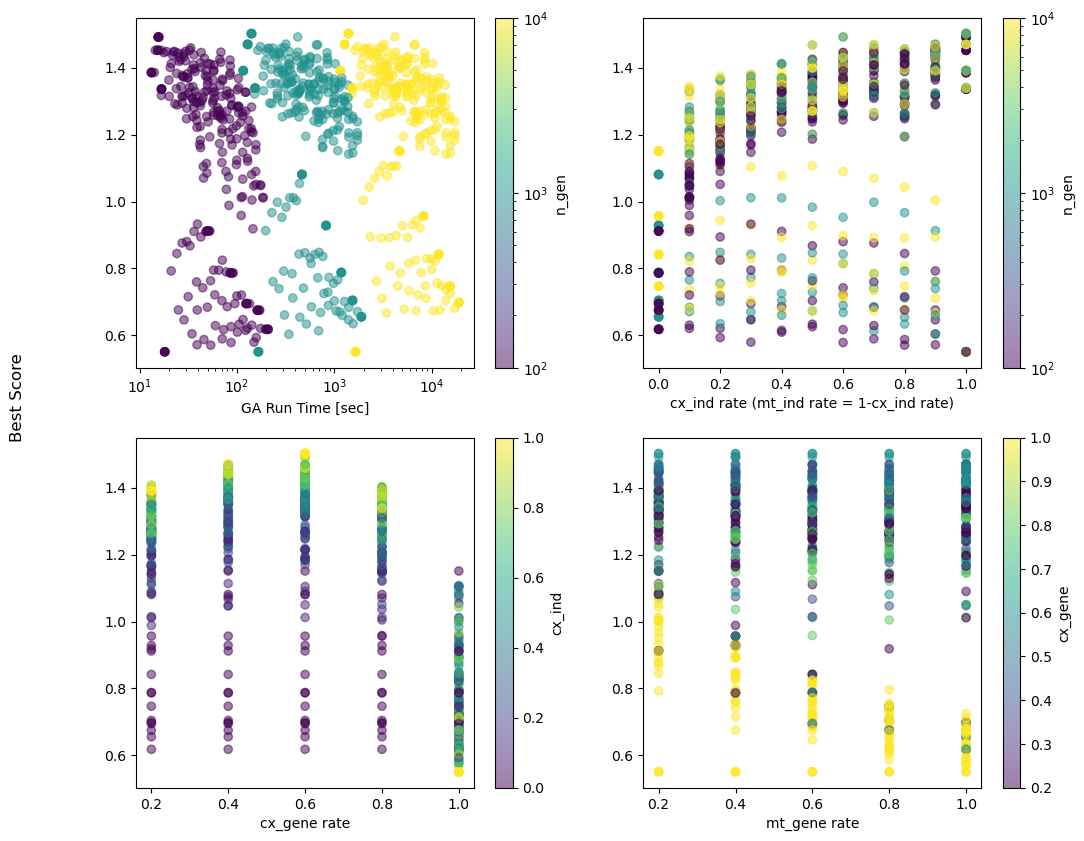

In [279]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
fig.supylabel('Best Score')
cmap = 'viridis'

# Score as a function of runtime
pcm = ax[0,0].scatter(results.loc[:,'time'], results.loc[:,'best'], c=results.loc[:,'n_gen'], cmap=cmap, norm=matplotlib.colors.LogNorm(), alpha=0.5)
fig.colorbar(pcm, ax=ax[0,0], label='n_gen')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('GA Run Time [sec]')

# Score as a function of crossover_individual/mutation_individual rate
pcm = ax[0,1].scatter(results.loc[:,'cx_ind'], results.loc[:,'best'], c=results.loc[:,'n_gen'], cmap=cmap, norm=matplotlib.colors.LogNorm(), alpha=0.5)
fig.colorbar(pcm, ax=ax[0,1], label='n_gen')
ax[0,1].set_xlabel('cx_ind rate (mt_ind rate = 1-cx_ind rate)')

# Score as a function of crossover_gene rate
pcm = ax[1,0].scatter(results.loc[:,'cx_gene'], results.loc[:,'best'], c=results.loc[:,'cx_ind'], cmap=cmap, alpha=0.5)
fig.colorbar(pcm, ax=ax[1,0], label='cx_ind')
ax[1,0].set_xlabel('cx_gene rate')

# Score as a function of mutation_gene rate
pcm = ax[1,1].scatter(results.loc[:,'mt_gene'], results.loc[:,'best'], c=results.loc[:,'cx_gene'], cmap=cmap, alpha=0.5)
fig.colorbar(pcm, ax=ax[1,1], label='cx_gene')
ax[1,1].set_xlabel('mt_gene rate')

Text(0.5, 0, 'mt_gene rate')

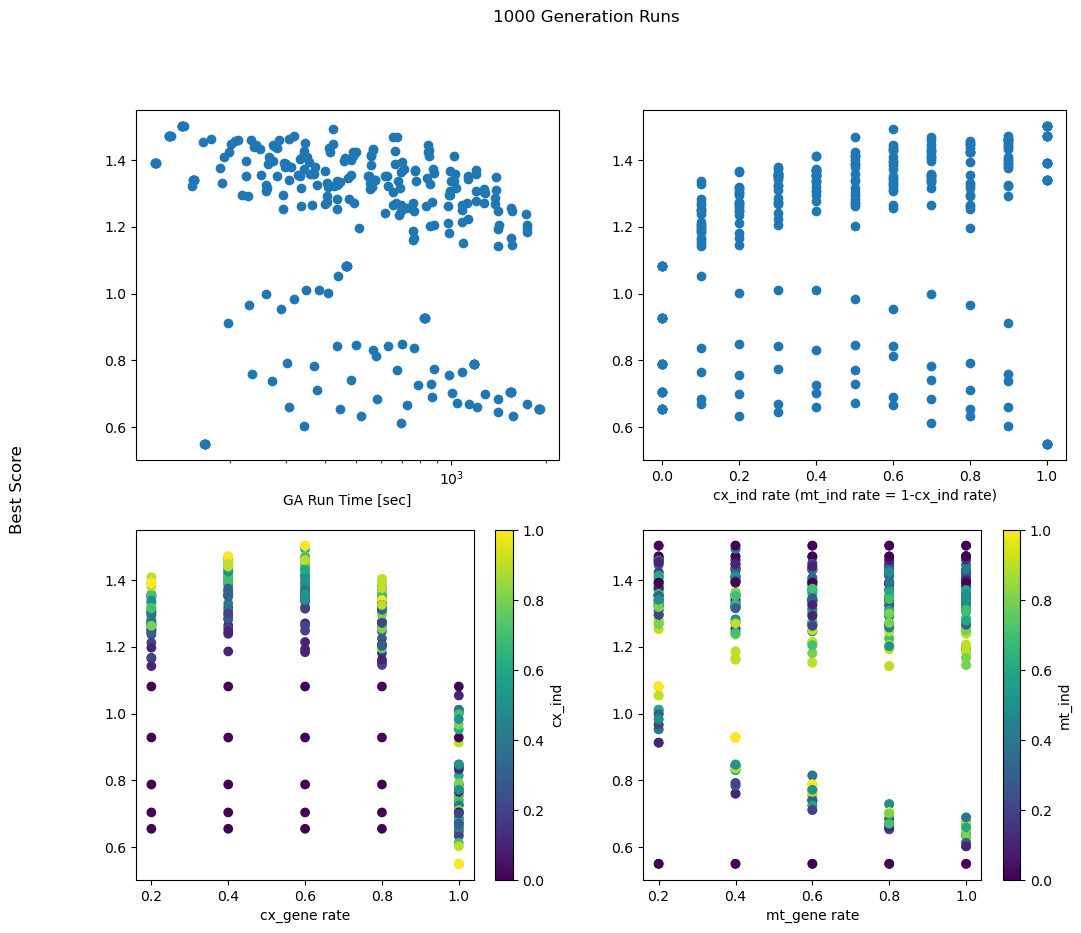

In [138]:
# Specific Generation Samples only
n_gen = 1000
fig, ax = plt.subplots(2,2, figsize=(12,10))
fig.suptitle(str(n_gen)+' Generation Runs')
fig.supylabel('Best Score')

results.loc[results.loc[:,'n_gen'] == n_gen]

# Score as a function of runtime
ax[0,0].scatter(results.loc[results.loc[:,'n_gen'] == n_gen]['time'], results.loc[results.loc[:,'n_gen'] == n_gen]['best'])
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('GA Run Time [sec]')

# Score as a function of crossover_individual/mutation_individual rate
ax[0,1].scatter(results.loc[results.loc[:,'n_gen'] == n_gen]['cx_ind'], results.loc[results.loc[:,'n_gen'] == n_gen]['best'])
ax[0,1].set_xlabel('cx_ind rate (mt_ind rate = 1-cx_ind rate)')

# Score as a function of the number of generations
#ax[0,2].scatter(results.loc[:,'n_gen'], results.loc[:,'best'])
#ax[0,2].set_xscale('log')
#ax[0,2].set_xlabel('Generations')

# Score as a function of crossover_gene rate
ax[1,0].scatter(results.loc[results.loc[:,'n_gen'] == n_gen]['cx_gene'], results.loc[results.loc[:,'n_gen'] == n_gen]['best'], c=results.loc[results.loc[:,'n_gen'] == n_gen]['cx_ind'], cmap='viridis')
fig.colorbar(ax[1,0].scatter(results.loc[results.loc[:,'n_gen'] == n_gen]['cx_gene'], results.loc[results.loc[:,'n_gen'] == n_gen]['best'], c=results.loc[results.loc[:,'cx_ind'] == n_gen]['best'], cmap='viridis'), ax=ax[1,0], label='cx_ind')
ax[1,0].set_xlabel('cx_gene rate')

# Score as a function of mutation_gene rate
ax[1,1].scatter(results.loc[results.loc[:,'n_gen'] == n_gen]['mt_gene'], results.loc[results.loc[:,'n_gen'] == n_gen]['best'], c=1-results.loc[results.loc[:,'n_gen'] == n_gen]['cx_ind'], cmap='viridis')
fig.colorbar(ax[1,1].scatter(results.loc[results.loc[:,'n_gen'] == n_gen]['mt_gene'], results.loc[results.loc[:,'n_gen'] == n_gen]['best'], c=1-results.loc[results.loc[:,'n_gen'] == n_gen]['cx_ind'], cmap='viridis'), ax=ax[1,1], label='mt_ind')
ax[1,1].set_xlabel('mt_gene rate')

In [105]:
results.loc[results.loc[:,'n_gen'] == 100]

1      1.067016
2      0.675329
3      0.958424
4      0.742361
7      1.047615
         ...   
422    0.675872
423    1.331082
424    0.593436
425    1.408266
426    1.365705
Name: best, Length: 275, dtype: object